In [1]:
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\timon\AppData\Local\Temp\ipykernel_21376\1492400551.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv('../data/apple_quality.csv', sep=',', header=0)
df = df.drop(columns=['A_id'])

print(df.tail())

print(df.dtypes)

          Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
3995  0.059386 -1.067408  -3.714549     0.473052   1.697986  2.244055   
3996 -0.293118  1.949253  -0.204020    -0.640196   0.024523 -1.087900   
3997 -2.634515 -2.138247  -2.440461     0.657223   2.199709  4.763859   
3998 -4.008004 -1.779337   2.366397    -0.200329   2.161435  0.214488   
3999  0.278540 -1.715505   0.121217    -1.154075   1.266677 -0.776571   

       Acidity Quality  
3995  0.137784     bad  
3996  1.854235    good  
3997 -1.334611     bad  
3998 -2.229720    good  
3999  1.599796    good  
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity        float64
Quality         object
dtype: object


Boxplot

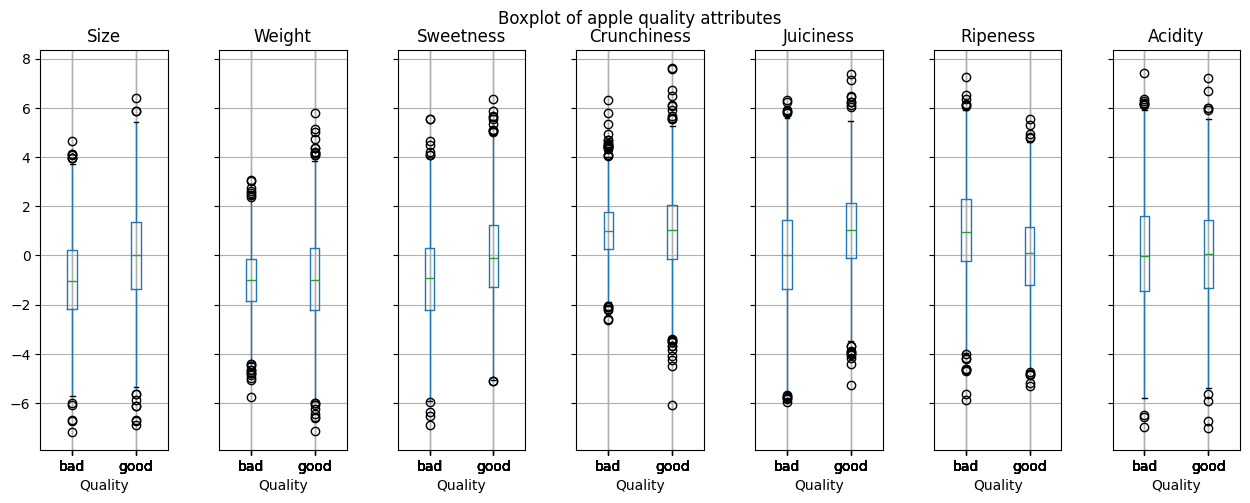

In [7]:
df.boxplot(column=['Size', 
                   'Weight', 
                   'Sweetness', 
                   'Crunchiness', 
                   'Juiciness', 
                   'Ripeness', 
                   'Acidity'], 
           by='Quality', 
           layout=(1, 7), 
           figsize=(15, 5))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

plt.suptitle('Boxplot of apple quality attributes')

plt.show()